In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####  use the prediction model to predict the results in the test dataset (validate the model performance)

In [6]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560_phylo')

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import warnings
from tqdm import tqdm
import os
from pathlib import Path
# Define the device
device = "cuda" if torch.cuda.is_available() else "mps" if  torch.backends.mps.is_available() else "cpu" # torch.has_mps or
print("Using device:", device)
if (device == 'cuda'):
    print(f"Device name: {torch.cuda.get_device_name(device.index)}")
    print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
elif (device == 'mps'):
    print(f"Device name: <mps>")
else:
    print("NOTE: If you have a GPU, consider using it for training.")
    print("      On a Windows machine with NVidia GPU, check this video: https://www.youtube.com/watch?v=GMSjDTU8Zlc")
    print("      On a Mac machine, run: pip3 install --pre torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/nightly/cpu")
device = torch.device(device)

Using device: cuda
Device name: Tesla T4
Device memory: 14.74810791015625 GB


In [8]:
ESP_test_df_enzy = torch.load('ESP_test_df_enzy.pt')
# Load the saved embeddings_results
ESP_test_df_smiles = torch.load('ESP_test_df_smiles.pt')
y_test = torch.load('ESP_test_df_label.pt')
ESP_test_df_enzy_add = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
ESP_test_df_smiles_add = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
y_test_add = torch.load('ESP_test_df_label_>2800_<8000.pt')

ESP_test_df_enzy = torch.cat([ESP_test_df_enzy, ESP_test_df_enzy_add], dim=0)
ESP_test_df_smiles = torch.cat([ESP_test_df_smiles, ESP_test_df_smiles_add], dim=0)
y_test = torch.cat([y_test, y_test_add], dim=0)
print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)

test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

# Create TensorDataset and DataLoaders
batch_size = 16
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)


torch.Size([13336, 2560]) torch.Size([13336, 768]) torch.Size([13336, 1])


In [9]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(2560, 2560) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(2560, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(2560)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [10]:
loss_fn = nn.MSELoss().to(device)

In [11]:
def run_validation(model, val_loader,loss_fn, device):
    model.eval()
    loss_sum = 0
    num_batch = len(val_loader)
    total_y_true=[]
    total_y_pred=[]
    total_y_prob=[]
    for ESP_val_df_enzy,ESP_val_df_smiles, y_val in val_loader:

        ESP_val_df_enzy = ESP_val_df_enzy.to(device)
        ESP_val_df_smiles = ESP_val_df_smiles.to(device)
        y_val = y_val.squeeze(1).to(device)

        refined_enzy_embed, refined_smiles_embed = model(ESP_val_df_enzy,ESP_val_df_smiles)
        cos_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
        loss = loss_fn(cos_sim, y_val).detach().cpu().numpy()


    tn,fp,fn,tp = confusion_matrix(arrange_y_true, arrange_y_pred).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    specificity = tn/(tn+fp)
    sensitivity = tp/(tp+fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    bacc = (sensitivity + specificity)/2
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    AUC = roc_auc_score(arrange_y_true, arrange_y_prob)
    f1 = 2*precision*recall/(precision+recall)
    print("loss_sum= ",loss_sum, "ACC= ",acc, "bacc= ",bacc, "precision= ",precision,"specificity= ",specificity, "sensitivity= ",sensitivity, "recall= ",recall, "MCC= ",MCC, "AUC= ",AUC, "f1= ",f1)
    return loss_sum, acc, bacc   # , precision, sensitivity, recall, MCC, AUC, f1


In [12]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560_phylo')

In [13]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_esm2_2560_fine_tuned_add_>2800_<8000__ACC=0.9476.pt'
# Load the entire model
model_test = torch.load(load_path)
run_validation(model_test,test_loader,loss_fn, device)

loss_sum=  0.04986711010312867 ACC=  0.9476604679064187 bacc=  0.9170804862959899 precision=  0.943639798488665 specificity=  0.9817718940936864 sensitivity=  0.8523890784982935 recall=  0.8523890784982935 MCC=  0.8628651785864061 AUC=  0.9652937024576622 f1=  0.8956963538553496


(0.04986711010312867, 0.9476604679064187, 0.9170804862959899)

In [14]:
## looks great because the loaded model is the correct model we plan to use for evaluation

In [45]:
model = model_test
model.eval()
loss_sum = 0
num_batch = len(test_loader)
total_y_true=[]
total_y_pred=[]
total_y_prob=[]
# collect all the cosine similarity scores among test dataset
cosine_sim_list = []
for ESP_val_df_enzy,ESP_val_df_smiles, y_val in test_loader:

    ESP_val_df_enzy = ESP_val_df_enzy.to(device)
    ESP_val_df_smiles = ESP_val_df_smiles.to(device)
    y_val = y_val.squeeze(1).to(device)

    refined_enzy_embed, refined_smiles_embed = model(ESP_val_df_enzy,ESP_val_df_smiles)
    cos_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
    cosine_sim_list = cosine_sim_list + cos_sim.detach().cpu().numpy().tolist()

    loss = loss_fn(cos_sim, y_val).detach().cpu().numpy()
    loss_sum = loss_sum + loss # count all the loss in the training process
    y_pred = (cos_sim > 0.5).float().cpu().numpy() # if score > 0.5, assign label 1 otherwise 0, transfer to cpu as numpy
    total_y_true.append(y_val.cpu().numpy())
    total_y_pred.append(y_pred)
    total_y_prob.append(cos_sim.detach().cpu().numpy())

loss_sum = loss_sum/num_batch # get the overall average loss (Notice: this method is not 100% accurate)

arrange_y_true = np.concatenate(total_y_true, axis=0)
arrange_y_pred = np.concatenate(total_y_pred, axis=0)
arrange_y_prob = np.concatenate(total_y_prob, axis=0)

In [50]:
arrange_y_true = arrange_y_true.tolist()
arrange_y_pred = arrange_y_pred.tolist()
arrange_y_prob = arrange_y_prob.tolist()

In [31]:
cosine_sim_list[0]

0.778714656829834

[array([ True,  True, False, ...,  True,  True,  True])]

In [ ]:
arrange_y_prob.tolist()

In [ ]:
bins

In [ ]:
[0] * (len(bins) - 1)

In [ ]:
arrange_y_prob

In [37]:
# 创建区间范围
bins = [round(x, 3) for x in list(np.arange(0, 1.025, 0.025))]
# 统计落在各区间内的数据个数
histogram = [0] * (len(bins) - 1)
histogram_correct
for i in range(len(arrange_y_prob)):
    value = arrange_y_prob[i]
    for i in range(len(bins) - 1):
        if bins[i] <= value < bins[i + 1]:
            histogram[i] += 1
            break

In [62]:
i=2
print(arrange_y_true[i],arrange_y_pred[i])

1.0 0.0


In [72]:
# 创建区间范围
bins = [round(x, 3) for x in list(np.arange(0, 1.025, 0.025))]
# 统计落在各区间内的数据个数
histogram_correct = [0] * (len(bins) - 1)
histogram_false = [0] * (len(bins) - 1)
for k in range(len(arrange_y_prob)):
    value = arrange_y_prob[k]
    for i in range(len(bins) - 1):
        if bins[i] <= value < bins[i + 1]:
            if arrange_y_true[k] == arrange_y_pred[k]:
                histogram_correct[i] += 1
            else :
                histogram_false[i] += 1
            break

In [82]:
combined = pd.concat([pd.DataFrame(histogram_correct), pd.DataFrame(histogram_false)],axis = 1)
combined.columns = ['Correct Predictions', 'Incorrect Predictions']
combined.to_csv('prediction score distribution.csv')

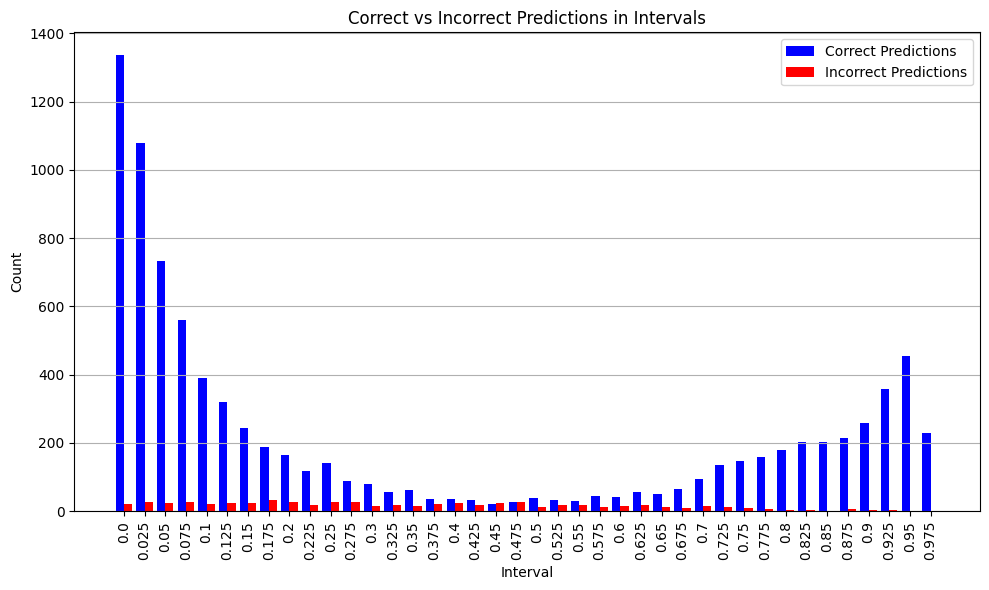

In [73]:
# 创建柱状图
fig, ax = plt.subplots(figsize=(10, 6))

# 柱子宽度
bar_width = 0.4

# 柱状图的位置
bar_positions = np.arange(len(bins) - 1)

# 绘制正确预测的柱状图（蓝色）
ax.bar(bar_positions - bar_width/2, histogram_correct, bar_width, label='Correct Predictions', color='blue')

# 绘制错误预测的柱状图（红色）
ax.bar(bar_positions + bar_width/2, histogram_false, bar_width, label='Incorrect Predictions', color='red')

# 设置图表标题和标签
ax.set_title('Correct vs Incorrect Predictions in Intervals')
ax.set_xlabel('Interval')
ax.set_ylabel('Count')
ax.set_xticks(bar_positions)
ax.set_xticklabels(bins[:-1], rotation=90)
ax.legend()

# 显示网格线
ax.grid(True, axis='y')

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

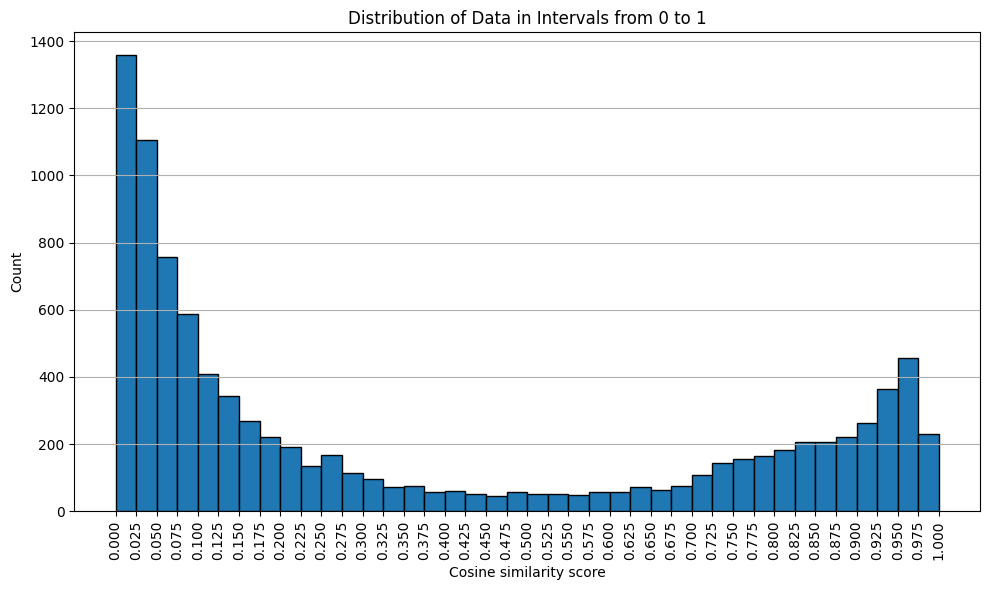

In [59]:
import matplotlib.pyplot as plt
# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], histogram, width=0.025, align='edge', edgecolor='black')
plt.xlabel('Cosine similarity score')
plt.ylabel('Count')
plt.title('Distribution of Data in Intervals from 0 to 1')
plt.grid(True, axis='y')
plt.xticks(bins, rotation=90)
plt.tight_layout()
plt.show()

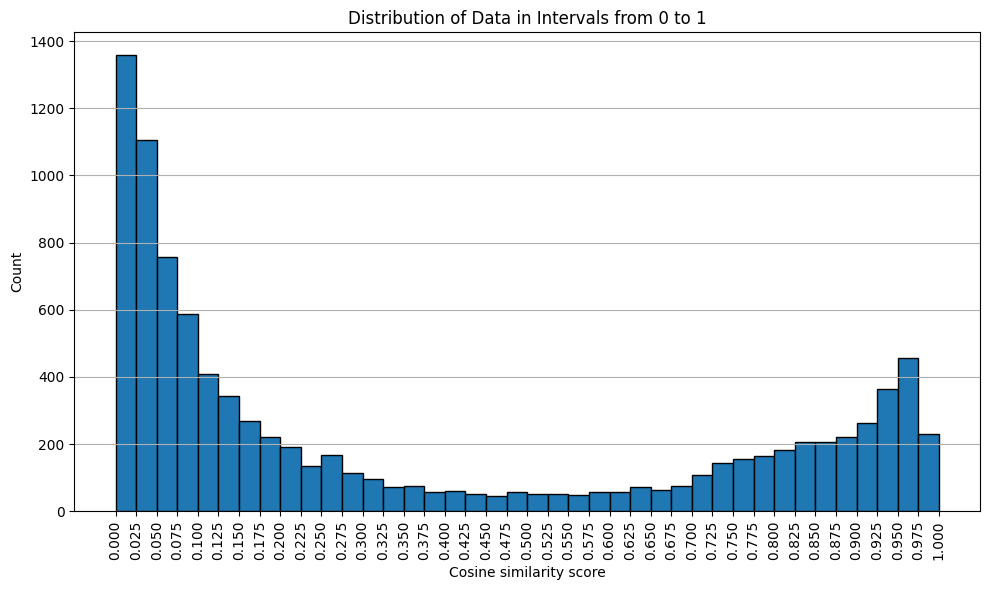

In [54]:
import matplotlib.pyplot as plt
# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], histogram, width=0.025, align='edge', edgecolor='black')
plt.xlabel('Cosine similarity score')
plt.ylabel('Count')
plt.title('Distribution of Data in Intervals from 0 to 1')
plt.grid(True, axis='y')
plt.xticks(bins, rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
for i in range(len(arrange_y_prob)):
  if arrange_y_prob